In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="6"
os.environ["NCCL_DEBUG"]="WARN"
#os.environ["NCCL_P2P_LEVEL"]="NODE"

In [2]:
import sys
sys.path.append("../../../")

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import omegaconf
import numpy as np
import matplotlib.pyplot as plt
from ganime.data.experimental import ImageDataset, VideoDataset
from ganime.model.vqgan_clean.vqgan import VQGAN
from ganime.visualization.videos import display_videos
from ganime.visualization.images import display_images
import tensorflow as tf
from datetime import datetime
from tqdm import tqdm
import os
from pyprojroot.pyprojroot import here
#tf.get_logger().setLevel('ERROR')

/usr/local/lib/python3.8/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /usr/local/lib/python3.8/dist-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [5]:
for device in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(device, True)

In [6]:
strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


2022-08-23 03:32:41.668727: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-23 03:32:42.158401: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46713 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:c1:00.0, compute capability: 8.6


In [7]:
cfg = omegaconf.OmegaConf.load(here("configs/kny_image_full_vgg19.yaml"))

In [8]:
num_workers = len(tf.config.list_physical_devices("GPU"))
batch_size = cfg["trainer"]["batch_size"] 
global_batch_size = batch_size * strategy.num_replicas_in_sync
n_epochs = cfg["trainer"]["n_epochs"] 
sample_batch_size = 8

In [9]:
#dataset_length = 34045 # KNY
dataset_length = 310153 #KNY full
#dataset_length = 20*10000 # MNIST
num_batch = dataset_length / batch_size

In [10]:
# Normalizing the images to [-1, 1]
def normalize(image):
    image = (tf.cast(image, tf.float32) / 127.5) - 1

    return image

In [11]:
def random_crop(image, img_height=64, img_width=128):
    cropped_image = tf.image.random_crop(image, size=[img_height, img_width, 3])

    return cropped_image

In [12]:
@tf.function()
def random_jitter(image):
    # Resizing to 72x142
    image = tf.image.resize(image, [72, 142], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # Random cropping back to 64x128
    image = random_crop(image)

    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        image = tf.image.flip_left_right(image)

    return image

In [13]:
def preprocess(image):
    image = tf.reshape(image, (tf.shape(image)[0], tf.shape(image)[1], 3))
    image = random_jitter(image)
    image = normalize(image)
    return image, image

In [14]:
dataset = ImageDataset("../../../data/kny/images_tfrecords_full").load()
dataset = dataset.shuffle(dataset_length, reshuffle_each_iteration=True, seed=10).map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

In [15]:
train_size = int(dataset_length * 0.8)
validation_size = int(dataset_length * 0.1)
test_size = int(dataset_length * 0.1)

In [16]:
train_ds = dataset.take(train_size)
validation_ds = dataset.skip(train_size).take(validation_size)#.padded_batch(global_batch_size).map(postprocess)
test_ds = dataset.skip(train_size + validation_size).take(validation_size)#.padded_batch(global_batch_size).map(postprocess)

In [17]:
train_sample_data = next(train_ds
                          .batch(sample_batch_size)
                          .prefetch(tf.data.AUTOTUNE).as_numpy_iterator())
validation_sample_data = next(validation_ds.batch(sample_batch_size).as_numpy_iterator())

2022-08-23 03:32:53.060646: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 107508 of 310153
2022-08-23 03:33:03.060849: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 213772 of 310153
2022-08-23 03:33:12.277201: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.
2022-08-23 03:33:22.845692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 242204 of 310153
2022-08-23 03:33:26.664920: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


In [18]:
train_ds = (train_ds.batch(global_batch_size, drop_remainder=True)
            .prefetch(tf.data.AUTOTUNE))
validation_ds = (validation_ds.batch(global_batch_size, drop_remainder=True)
            .prefetch(tf.data.AUTOTUNE))
test_ds = (test_ds.batch(global_batch_size, drop_remainder=True)
            .prefetch(tf.data.AUTOTUNE))

In [19]:
from ganime.visualization.images import display_true_pred

In [20]:
with strategy.scope():
    vqgan = VQGAN(**cfg["model"], num_replicas=strategy.num_replicas_in_sync)

Working with z of shape (1, 512, 16, 16) = 131072 dimensions.
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:lo

In [21]:
with strategy.scope():
    gen_optimizer = tf.keras.optimizers.Adam(
                learning_rate=cfg["trainer"]["gen_lr"],
                beta_1=cfg["trainer"]["gen_beta_1"],
                beta_2=cfg["trainer"]["gen_beta_2"],
                clipnorm=cfg["trainer"]["gen_clip_norm"],
    )
    disc_optimizer = tf.keras.optimizers.Adam(
        learning_rate=cfg["trainer"]["disc_lr"],
        beta_1=cfg["trainer"]["disc_beta_1"],
        beta_2=cfg["trainer"]["disc_beta_2"],
        clipnorm=cfg["trainer"]["disc_clip_norm"],
    )
    vqgan.compile(gen_optimizer=gen_optimizer, disc_optimizer=disc_optimizer)

In [22]:
with strategy.scope():
    x = train_sample_data[0]
    generated = vqgan(x[:10])[0]

2022-08-23 03:33:37.909691: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100
2022-08-23 03:33:39.045144: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


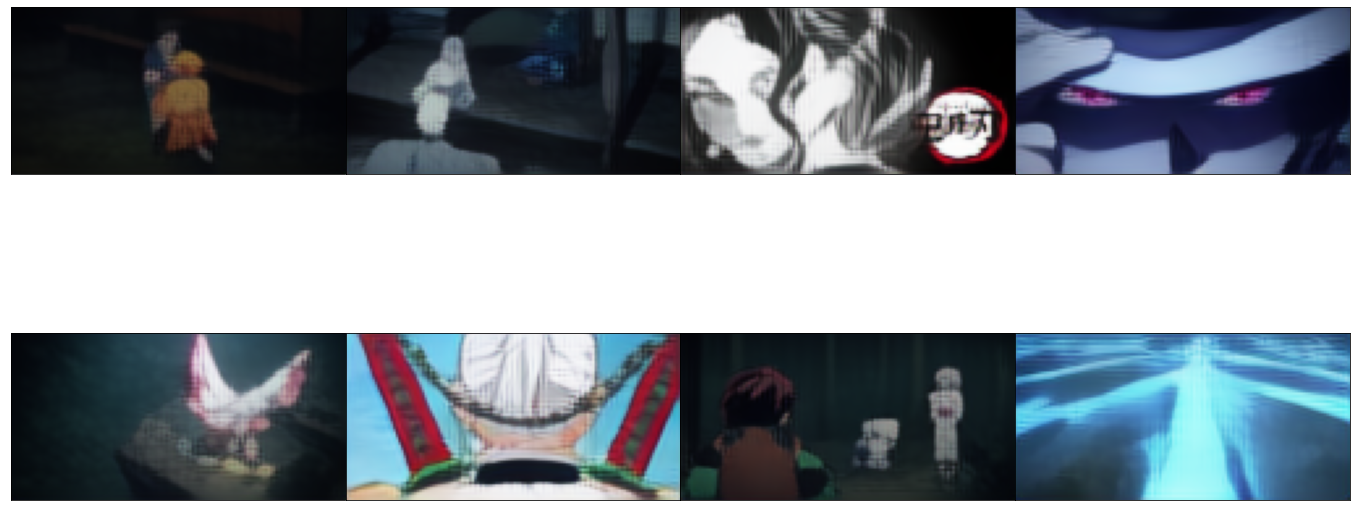

In [23]:
display_images(generated, n_rows=2, n_cols=4)
print()

In [32]:
from ganime.metrics.image import calculate_images_metrics

In [53]:
dataset = ImageDataset("../../../data/kny/images_tfrecords_full").load()
dataset = dataset.shuffle(dataset_length, reshuffle_each_iteration=True).map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

batch_size = 128

train_ds = dataset.take(train_size)
validation_ds = dataset.skip(train_size).take(validation_size)#.padded_batch(global_batch_size).map(postprocess)
test_ds = dataset.skip(train_size + validation_size).take(validation_size)#.padded_batch(global_batch_size).map(postprocess)

train_ds = (train_ds.batch(batch_size, drop_remainder=True)
            .prefetch(tf.data.AUTOTUNE))
validation_ds = (validation_ds.batch(batch_size, drop_remainder=True)
            .prefetch(tf.data.AUTOTUNE))
test_ds = (test_ds.batch(batch_size, drop_remainder=True)
            .prefetch(tf.data.AUTOTUNE))

In [54]:
metrics_test = [calculate_images_metrics(test_ds, vqgan, validation_size // batch_size) for i in range(5)]
metrics_test

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

[{'fid': 16.033145948466228, 'ssim': 0.65928715, 'psnr': 17.420517},
 {'fid': 16.209787298091992, 'ssim': 0.6587225, 'psnr': 17.386448},
 {'fid': 16.155234344652236, 'ssim': 0.6610118, 'psnr': 17.499224},
 {'fid': 16.008273835039375, 'ssim': 0.65917224, 'psnr': 17.404661},
 {'fid': 15.937108949378477, 'ssim': 0.6604405, 'psnr': 17.403728}]

In [55]:
metrics_train = [calculate_images_metrics(train_ds, vqgan, train_size // batch_size) for i in range(5)]
metrics_train

  0%|          | 0/1938 [00:00<?, ?it/s]

2022-08-23 05:12:57.772444: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2032140288 exceeds 10% of free system memory.
2022-08-23 05:12:58.835986: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2032140288 exceeds 10% of free system memory.


  0%|          | 0/1938 [00:00<?, ?it/s]

2022-08-23 05:32:30.913166: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2032140288 exceeds 10% of free system memory.
2022-08-23 05:32:31.952433: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2032140288 exceeds 10% of free system memory.


  0%|          | 0/1938 [00:00<?, ?it/s]

2022-08-23 05:52:00.592418: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2032140288 exceeds 10% of free system memory.


  0%|          | 0/1938 [00:00<?, ?it/s]

  0%|          | 0/1938 [00:00<?, ?it/s]

[{'fid': 14.764342144164605, 'ssim': 0.65942967, 'psnr': 17.428297},
 {'fid': 14.765167558305743, 'ssim': 0.659607, 'psnr': 17.432503},
 {'fid': 14.750979439746548, 'ssim': 0.65940744, 'psnr': 17.424044},
 {'fid': 14.779027384836244, 'ssim': 0.65952605, 'psnr': 17.436796},
 {'fid': 14.760784909870779, 'ssim': 0.6596203, 'psnr': 17.441114}]

In [56]:
from ganime.model.vqgan_clean.discriminator.model_bkp import NLayerDiscriminator

In [68]:
disc = NLayerDiscriminator()

In [69]:
inp = tf.keras.layers.Input(shape=(64, 128, 3))
disc = tf.keras.Model(inputs=[inp], outputs=disc.call(inp))

In [71]:
disc.summary(150)

Model: "model_9"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                                      Output Shape                                                Param #                
 input_40 (InputLayer)                                             [(None, 64, 128, 3)]                                        0                      
                                                                                                                                                      
 conv2d_2531 (Conv2D)                                              (None, 64, 128, 64)                                         3136                   
                                                                                                                                                      
 leaky_re_lu_16 (LeakyReLU)                                        (None, 64,